In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import threshold_mean
import scipy.ndimage as ndi
import sys
import os

sys.path.append('../')
from src.functions import get_parameters
from src.functions import get_key_file

In [20]:
parameter_local_path = '../conf/local/parameters.yml'

parameters = get_parameters(parameter_local_path)

base_folder = parameters["data_dir"]
out_folder = parameters["out_dir"]
key_file_path = parameters["key_file"]

plot_width = 7
plot_height = 7
channel_artery = 1

key_file = get_key_file(parameters)

print(key_file.columns)
display(key_file)

Parameters: 
{'key_file': '/media/fjodor/Elephant/Dropbox/MDC_Projects/Manuscript_HHT/migration_assay/in_vivo/mosaic_EC/2024-06-30_keyfile.xls', 'data_dir': '/media/fjodor/Elephant/Dropbox/MDC_Projects/Manuscript_HHT/', 'out_dir': '/media/fjodor/Elephant/Dropbox/MDC_Projects/Manuscript_HHT/migration_assay/in_vivo/output/', 'experiment_IDs_exclude': [], 'pixel_no_per_retina': 10000, 'image_types': ['GFP'], 'load_conditions': ['CDH5CreERT2;iSureCre;YesFloxFlox', 'CDH5CreERT2 iSureCre'], 'plot_kde': False, 'plot_individual_hist': False, 'plot_cond_kde': True, 'radial_bins': [[0, 1200]], 'time_points': ['P3_P7', 'P3_P15'], 'number_ks_test': 1}
Index(['filename', 'ExperimentID', 'Cdh5CreERT2 mTmG',
       'Cdh5CreERT2;mTmG;SMAD4FloxFlox', 'Cdh5CreERT2;mTmG;Alk1FloxFlox',
       'Drawn', 'Unnamed: 6', 'GFP', 'Unnamed: 8', 'IB4',
       'THO Injection Point', 'Collection Point', 'Pixel size in um'],
      dtype='object')


,filename,ExperimentID,Cdh5CreERT2 mTmG,Cdh5CreERT2;mTmG;SMAD4FloxFlox,Cdh5CreERT2;mTmG;Alk1FloxFlox,Drawn,Unnamed: 6,GFP,Unnamed: 8,IB4,THO Injection Point,Collection Point,Pixel size in um
0,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,1,0,0,1,0,NaN,1,NaN,0,5,8,2.273761
1,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,1,0,0,1,1,NaN,0,NaN,0,5,8,2.273761
2,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,2,0,0,1,0,NaN,1,NaN,0,5,8,2.273761
3,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,2,0,0,1,1,NaN,0,NaN,0,5,8,2.273761
4,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,3,0,0,1,0,NaN,1,NaN,0,5,8,2.273761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P1...,53,0,0,1,1,NaN,0,NaN,0,5,15,2.273761
106,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,54,0,0,1,0,NaN,1,NaN,0,5,8,2.273761
107,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,54,0,0,1,1,NaN,0,NaN,0,5,8,2.273761
108,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,55,0,0,1,0,NaN,1,NaN,0,5,8,2.273761


1


,filename,ExperimentID,Cdh5CreERT2 mTmG,Cdh5CreERT2;mTmG;SMAD4FloxFlox,Cdh5CreERT2;mTmG;Alk1FloxFlox,Drawn,Unnamed: 6,GFP,Unnamed: 8,IB4,THO Injection Point,Collection Point,Pixel size in um
0,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,1,0,0,1,0,NaN,1,NaN,0,5,8,2.273761
1,migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8...,1,0,0,1,1,NaN,0,NaN,0,5,8,2.273761


/media/fjodor/Elephant/Dropbox/MDC_Projects/Manuscript_HHT/migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8/20240215_p5_p8_alk1_cdh5_mtmg_1_Merged/output_retina_1/GFP_mask.ome.tif
/media/fjodor/Elephant/Dropbox/MDC_Projects/Manuscript_HHT/migration_assay/in_vivo/mosaic_EC/Alk1_mTmG/P8/20240215_p5_p8_alk1_cdh5_mtmg_1_Merged/output_retina_1/Drawn.ome.tif
Shape of drawn image:
(5, 2351, 2351)


TypeError: not all arguments converted during string formatting

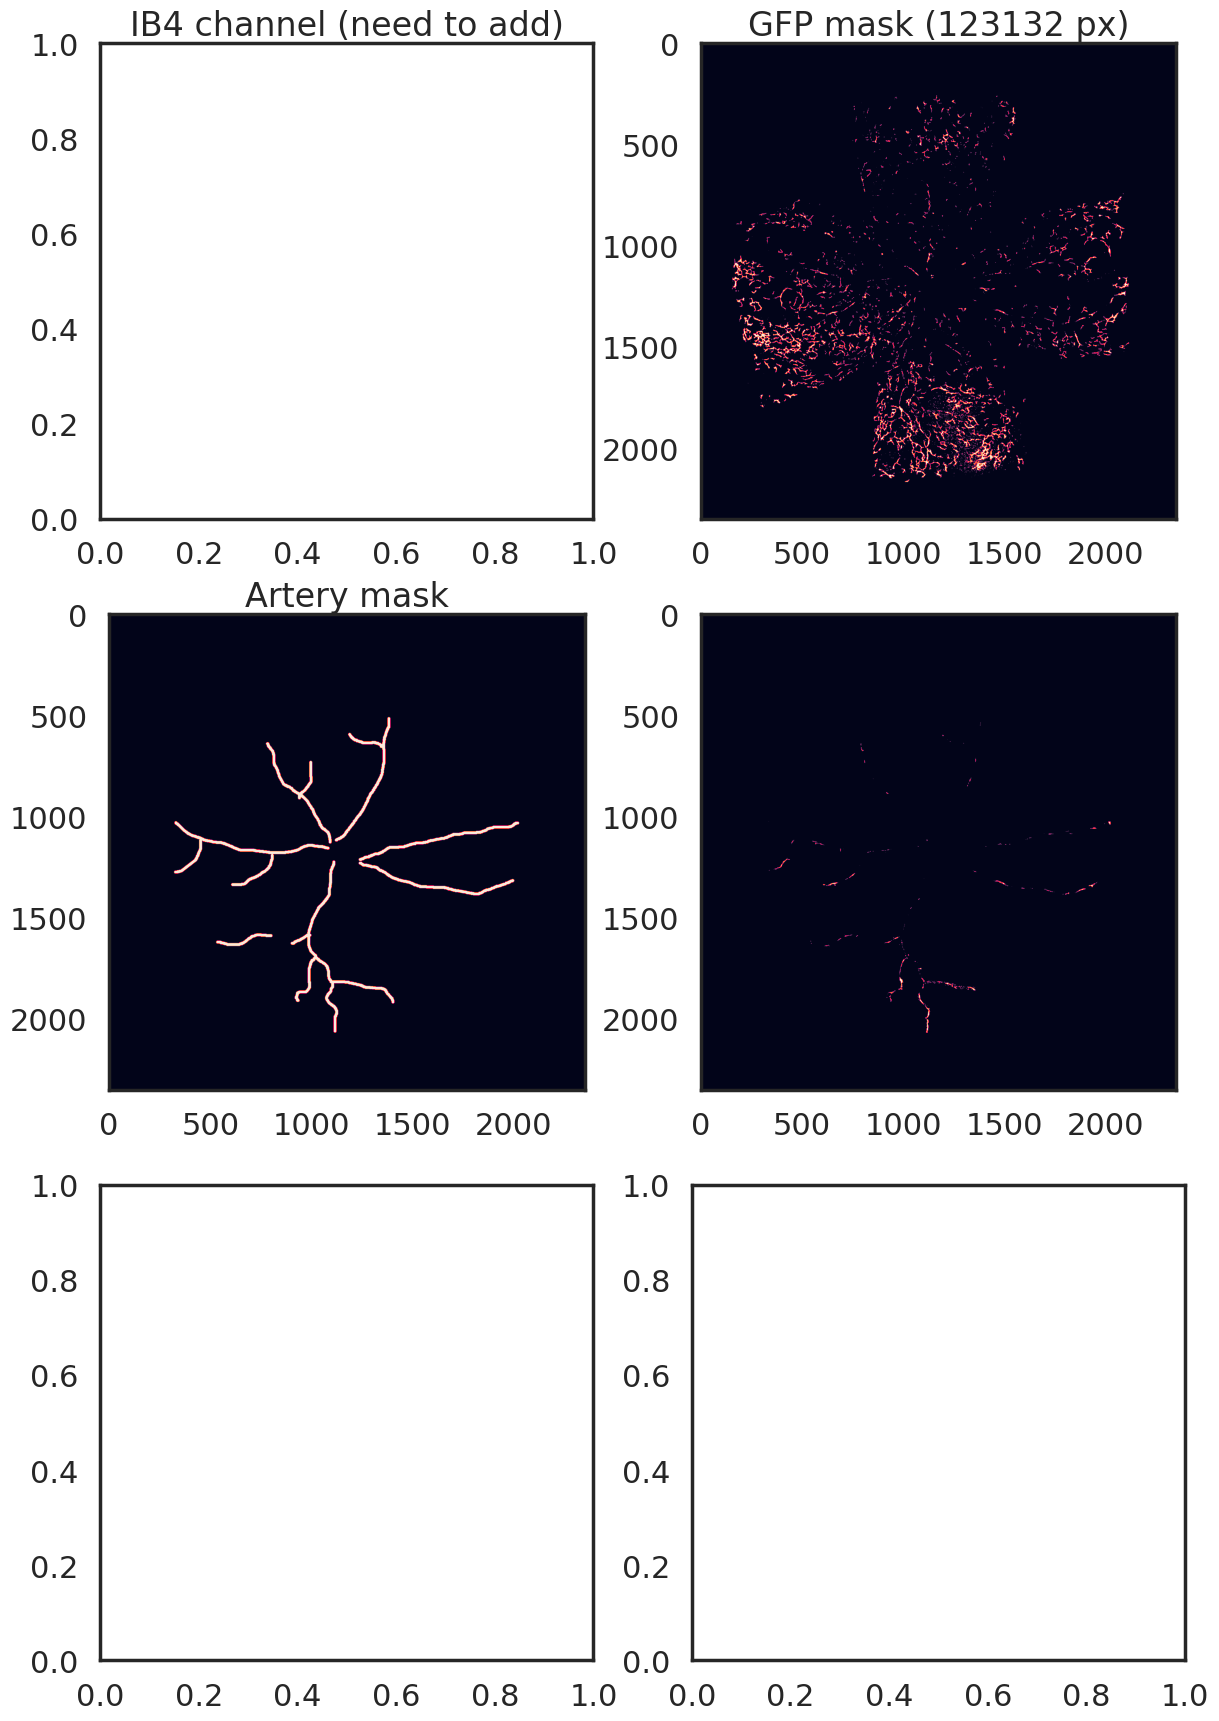

In [21]:
summary_data = pd.DataFrame()
counter = 0

experiment_IDs = key_file["ExperimentID"].unique() #[70:]
#experiment_IDs = [10]

experiment_IDs_exclude = []

for experiment_ID in experiment_IDs:
    print(experiment_ID)
    if experiment_ID in experiment_IDs_exclude:
        print("Excluded experiment ID: %s" % experiment_ID)
        continue
    experiment_key = key_file[key_file["ExperimentID"] == experiment_ID]
        
    display(experiment_key)

    filename_GFP = base_folder
    filename_drawn = base_folder
    
    count_img = 0
    for index, row in experiment_key.iterrows():
        
        if row["GFP"] == 1:
            filename_GFP = base_folder + row["filename"]
            count_img += 1
        if row["Drawn"] == 1:
            filename_drawn =  base_folder + row["filename"]
            count_img += 1
            
    if count_img != 2:
        print("Need exactly 2 images, but %s were given!" % count_img)
        continue

    condition = "NA"
    if experiment_key["Cdh5CreERT2 mTmG"].values[0] == 1:
        condition = "control"
    if experiment_key["Cdh5CreERT2;mTmG;SMAD4FloxFlox"].values[0] == 1:
        condition = "SMAD4-KO"
    if experiment_key["Cdh5CreERT2;mTmG;Alk1FloxFlox"].values[0] == 1:
        condition = "ALK1-KO"

    print(filename_GFP)
    print(filename_drawn)
    
    img_GFP = np.array(io.imread(filename_GFP))
    thresh_img_GFP = img_GFP > threshold_mean(img_GFP)
    unique_GFP, counts_GFP = np.unique(thresh_img_GFP, return_counts = True)    
    if counts_GFP[1] > counts_GFP[0]:
        thresh_img_GFP = img_GFP < threshold_mean(img_GFP)
        unique_GFP, counts_GFP = np.unique(thresh_img_GFP, return_counts = True)    

    img_drawn = np.array(io.imread(filename_drawn))
    print("Shape of drawn image:")
    print(img_drawn.shape)
    img_artery = img_drawn[1,:,:]
    thresh_img_artery = img_artery > threshold_mean(img_artery)
    GFP_artery = np.logical_and(thresh_img_GFP,thresh_img_artery)
    
    img_vein = img_drawn[2,:,:]
    thresh_img_vein = img_vein > threshold_mean(img_vein)
    GFP_vein = np.logical_and(thresh_img_GFP,thresh_img_vein)
    
    counts_GFP_artery = np.count_nonzero(GFP_artery)
    counts_GFP_vein = np.count_nonzero(GFP_vein)
    counts_artery = np.count_nonzero(thresh_img_artery)
    counts_vein = np.count_nonzero(thresh_img_vein)     
    
    summary_data.at[counter,"ExperimentID"] = experiment_ID
    summary_data.at[counter,"condition"] = condition
    summary_data.at[counter,"collection_time"] = row["Collection Point"]
    summary_data.at[counter,"GFP_px"] = counts_GFP[1]
    summary_data.at[counter,"GFP_artery_px"] = counts_GFP_artery
    summary_data.at[counter,"GFP_vein_px"] = counts_GFP_vein
    summary_data.at[counter,"artery_px"] = counts_artery
    summary_data.at[counter,"vein_px"] = counts_vein

    
    
    fig, ax = plt.subplots(3,2, figsize=(2*plot_width, 3*plot_height))
    ax[0,0].set_title("IB4 channel (need to add)")
    ax[0,1].imshow(thresh_img_GFP)
    ax[0,1].set_title("GFP mask (%s px)" % counts_GFP[1])
    ax[1,0].imshow(thresh_img_artery)
    ax[1,0].set_title("Artery mask")
    ax[1,1].imshow(GFP_artery)
    percent = np.round(100*counts_GFP_artery/counts_GFP[1],2)
    ax[1,1].set_title("GFP in artery (%s px / %s %%)" % (counts_GFP_artery, percent))
    ax[2,0].imshow(thresh_img_vein)
    ax[2,0].set_title("Vein mask")
    ax[2,1].imshow(GFP_vein)
    percent = np.round(100*counts_GFP_vein/counts_GFP[1],2)
    ax[2,1].set_title("GFP in vein (%s px / %s %%)" % (counts_GFP_vein,  percent))

    # Check if the folder exists, if not, create it
    out_folder_validation = out_folder + "validation_images/"
    if not os.path.exists(out_folder_validation):
        os.makedirs(out_folder_validation)
        print(f"Folder created: {out_folder_validation}")
    else:
        print(f"Folder already exists: {out_folder_validation}")

    plt.savefig(out_folder_validation + "masks_experiment_id_%s.png" % experiment_ID)
    plt.close()


    fig, ax = plt.subplots(3,2, figsize=(2*plot_width, 3*plot_height))
    artery_distance = ndi.morphology.distance_transform_edt(np.invert(thresh_img_artery))#*scale_factor
    #artery_distance_flat = artery_distance.flatten()
    vein_distance = ndi.morphology.distance_transform_edt(np.invert(thresh_img_vein))#*scale_factor
    #vein_distance_flat = vein_distance.flatten()


    va_sum = artery_distance + vein_distance
    va_dist = vein_distance/va_sum
    va_gfp_dist = thresh_img_GFP*va_dist

    venous_bed_ = va_dist < 0.5
    arterial_bed_ = va_dist > 0.5

    venous_bed = np.logical_xor(venous_bed_,thresh_img_vein)
    arterial_bed = np.logical_xor(arterial_bed_,thresh_img_artery)

    GFP_arterial_bed = np.logical_and(thresh_img_GFP, arterial_bed)
    GFP_venous_bed = np.logical_and(thresh_img_GFP, venous_bed)

    counts_GFP_arterial_bed = np.count_nonzero(GFP_arterial_bed)
    counts_GFP_venous_bed = np.count_nonzero(GFP_venous_bed)
    
    ax[0,0].imshow(artery_distance)
    ax[0,0].set_title("Artery distance")
    ax[0,1].imshow(vein_distance)
    ax[0,1].set_title("Vein distance")
    ax[1,0].imshow(va_dist)
    ax[1,0].set_title("VA distance")
    ax[1,1].imshow(va_gfp_dist)
    ax[1,1].set_title("VA distance with GFP")
    ax[2,0].imshow(venous_bed)
    ax[2,0].set_title("Venous bed")
    ax[2,1].imshow(arterial_bed)
    ax[2,1].set_title("Arterial bed")

    plt.savefig(out_folder_validation + "va_distance_experiment_id_%s.png" % experiment_ID)
    plt.close()

    summary_data.at[counter,"GFP_arterial_bed_px"] = counts_GFP_arterial_bed
    summary_data.at[counter,"GFP_venous_bed_px"] = counts_GFP_venous_bed

    summary_data.to_csv(out_folder + "summary_data.csv", index=False)

    counter += 1    